<a href="https://www.kaggle.com/code/aniruddhapa/named-entity-recognition-for-unstructured-text?scriptVersionId=194292614" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

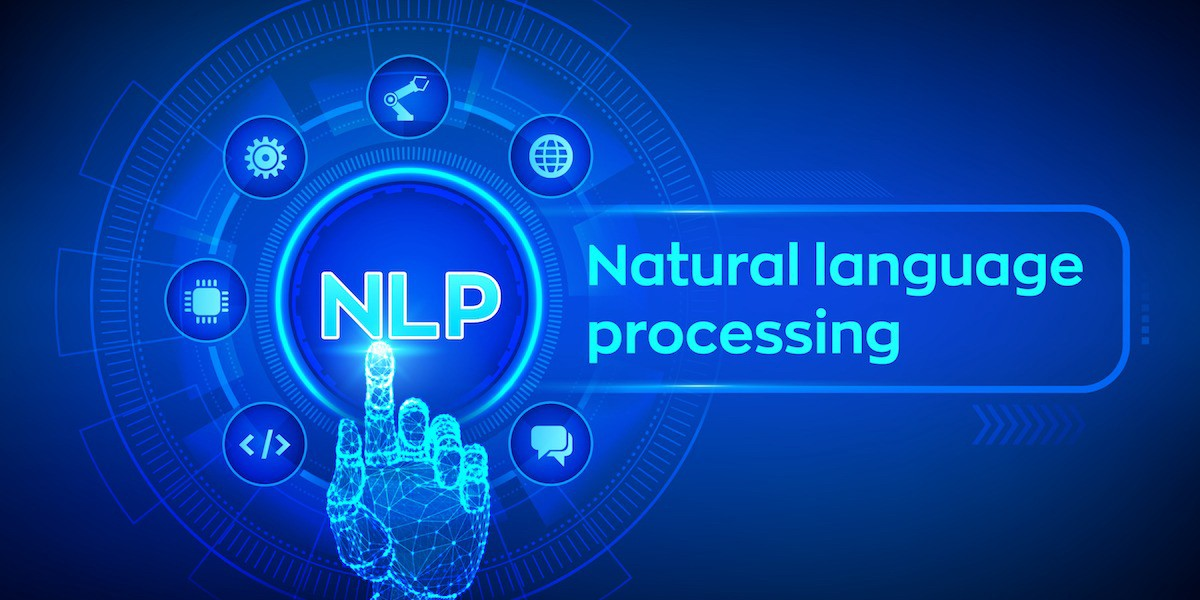

# Named Entity Recognition (NER)

* This notebook solves the named entity recognition (NER) problem using deep learning. 

* The NER problem involves identifying and classifying named entities (such as people, organizations, and locations) in unstructured text data. 

* The code imports various libraries, including Pandas for data manipulation, NumPy for numerical computing, and TensorFlow and Keras for deep learning.

**What is Named Entity Recogniton**

Named Entity Recognition (NER) is a natural language processing (NLP) technique that involves identifying and classifying named entities in unstructured text data. A named entity is any word or phrase that refers to a specific entity, such as a person, organization, location, date, time, currency, etc.

**Why NER**

The goal of NER is to automatically identify and classify named entities in text data, so that they can be used for various downstream NLP tasks such as information extraction, question answering, and sentiment analysis. NER systems typically use machine learning algorithms to automatically label words or phrases in text data with pre-defined entity types.

**Challenges of NER**

NER can be a challenging task, as named entities can appear in various forms and contexts in text data. For example, the same entity can be referred to using different names, abbreviations, or aliases, and can also be mentioned in different contexts, such as within sentences, across paragraphs or documents.


**Real Life Applications of NER**

Despite these challenges, NER has a wide range of applications in various domains, including social media monitoring, fraud detection, customer support, news analysis, and more. It can help businesses and organizations to automate and optimize their workflows, improve their customer experience, and gain valuable insights from text data.

In [1]:
#import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional
plt.style.use('seaborn')

In [2]:
data=pd.read_csv('/kaggle/input/ner-dataset/ner_datasetreference.csv',encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
#Delete the POS column as we do not need it
data.drop('POS',axis='columns',inplace=True)

In [4]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [5]:
#NaN values to be filled using Forward Fill method.
data=data.fillna(method='ffill')

In [6]:
data.head(35)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


# Creating a list of unique words from dataset 'data'

This following code extracts the values in the "Word" column of the data dataset and converts them into a Python set to remove any duplicates. The set function returns a collection of unique elements in an 
unordered fashion. The list function is used to convert the set back to a list so that the words can 
be indexed.

Then it adds a new string element with the value "ENDPAD" to the end of the words list.

In [7]:
words=list(set(data['Word'].values))
words.append("ENDPAD")
words[-1]

'ENDPAD'

In [8]:
#Total no. of words
num_words=len(words)
print("Total number of words",num_words)

Total number of words 35179


In [9]:
#List of Tags and total no. of Tags
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: B-eve, O, I-gpe, B-tim, B-art, I-art, I-eve, I-org, I-per, B-gpe, I-tim, I-nat, B-nat, B-geo, B-org, I-geo, B-per
Total Number of tags 17


In [10]:
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O


# Creating a class which will give the complete sentence with Tags attached with each word

In [11]:
class Get_sentence(object):
  def __init__(self,data):
    self.n_sent=1
    self.data=data
    
    """The following line defines a lambda function called agg_func. The function takes a pandas DataFrame s as an 
    argument and returns a list of tuples, where each tuple contains a word and its corresponding tag. 
    The lambda function is used to group the words and tags in each sentence together."""
    
    agg_func=lambda s:[(w,t) for w,t in zip(s['Word'].tolist(),s['Tag'].tolist())]
    
    ''' The following line creates a new instance variable called 'grouped' by grouping the data DataFrame by the 
    "Sentence #" column and applying the agg_func function to each group. The result is a new pandas 
    DataFrame where each row represents a sentence and contains a list of tuples, where each tuple 
    contains a word and its corresponding tag.'''
    
    self.grouped=self.data.groupby('Sentence #').apply(agg_func)
    
    ''' The following line creates a new instance variable called sentences by iterating over the rows in the 
    grouped DataFrame and adding each row to a list. The result is a list of sentences, where each 
    sentence is a list of tuples, where each tuple contains a word and its corresponding tag.'''
    
    self.sentences=[s for s in self.grouped]

In [12]:
'''This code creates an instance of the Get_sentence class and uses it to extract sentences from a dataset "data" '''

getter=Get_sentence(data)
sentence=getter.sentences

In [13]:
sentence[1]

[('Iranian', 'B-gpe'),
 ('officials', 'O'),
 ('say', 'O'),
 ('they', 'O'),
 ('expect', 'O'),
 ('to', 'O'),
 ('get', 'O'),
 ('access', 'O'),
 ('to', 'O'),
 ('sealed', 'O'),
 ('sensitive', 'O'),
 ('parts', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('plant', 'O'),
 ('Wednesday', 'B-tim'),
 (',', 'O'),
 ('after', 'O'),
 ('an', 'O'),
 ('IAEA', 'B-org'),
 ('surveillance', 'O'),
 ('system', 'O'),
 ('begins', 'O'),
 ('functioning', 'O'),
 ('.', 'O')]

# Data Visualization

##### Distribution of sentence lengths in a list of sentences using a histogram

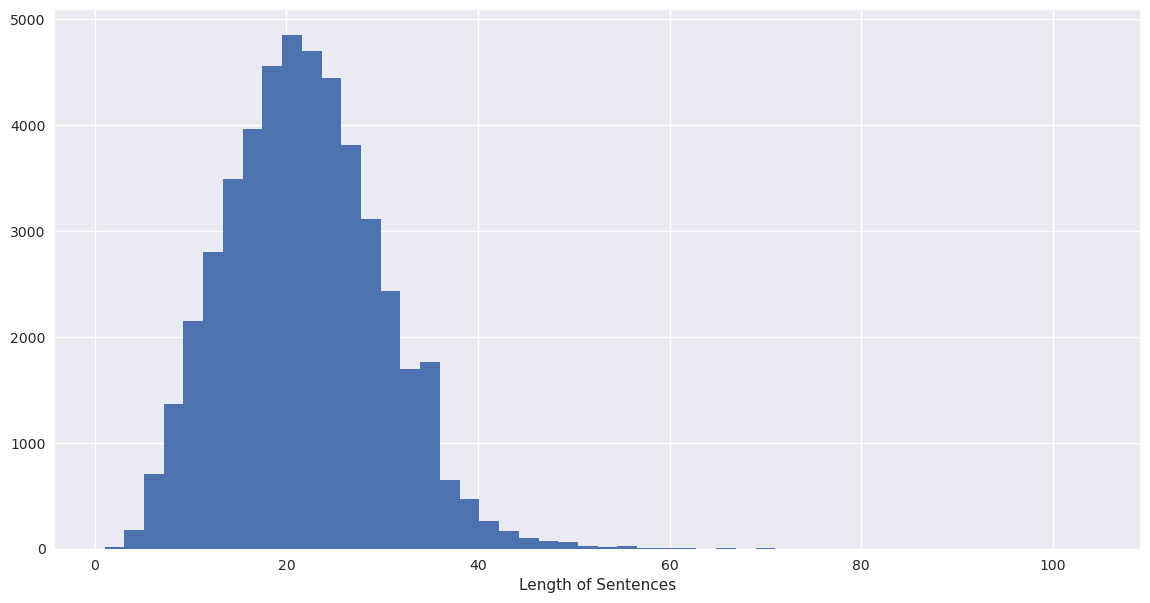

In [14]:
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentence],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

* Most of our sentenses have a length of 20 words, the longest sentense is around 63 words

#### Horizontal bar plot of the frequency of non-"O"(Non-Entity Token) tags in the dataset

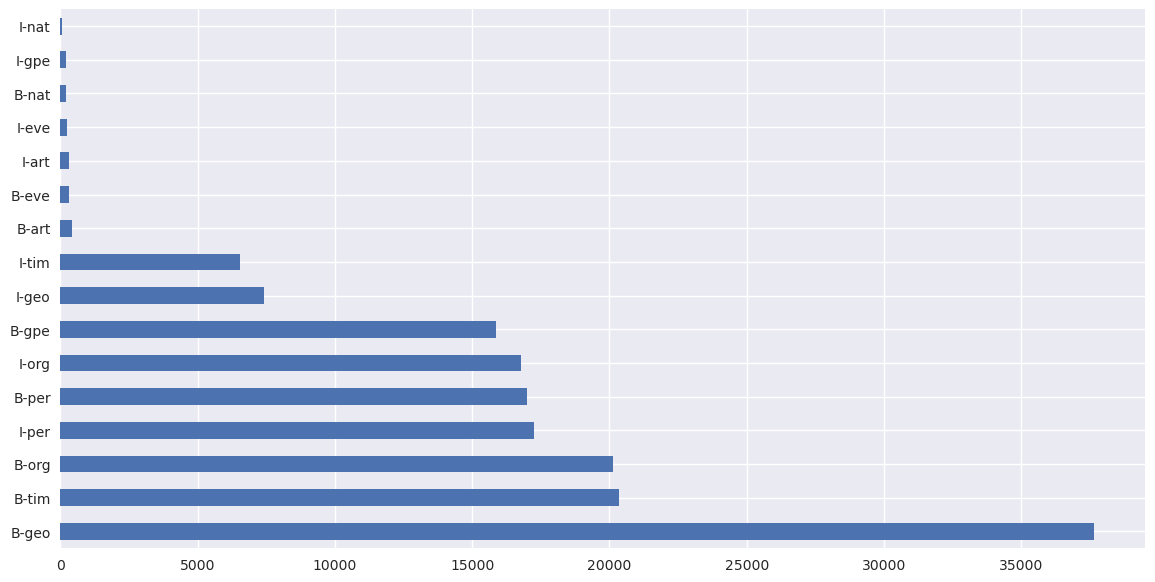

In [15]:
plt.figure(figsize=(14, 7))
data.Tag[data.Tag != 'O']\
    .value_counts()\
    .plot\
    .barh();

* We can understand from the bar chart above that B-geo Tags are over-represented. 

* I-nat and I-gpe Tags are negligible and almost non-existent. Model will have difficulty in classifying these 2 tags.

# Data Preparation

In [16]:
#creating two dictionaries to map words and tags to their corresponding indices
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [17]:
# Padding our sentences using max lenght of 50.
max_len=50
X=[[word_idx[w[0]] for w in s] for s in sentence]
X=pad_sequences(maxlen=max_len,sequences=X,padding='post',value=num_words-1)
y=[[tag_idx[w[1]]for w in s]for s in sentence]
y=pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag_idx['O'])

In [18]:
X[0]

array([26065, 12003,  7576,  2458, 32984, 21046, 34911, 21918,  6816,
       18447, 18514, 29978, 35071,    22, 17503, 18447, 12582, 12003,
       19835,  2974, 32295, 15915, 25529, 24543, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [19]:
y[0]

array([ 1,  1,  1,  1,  1,  1, 13,  1,  1,  1,  1,  1, 13,  1,  1,  1,  1,
        1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int32)

Now, the following code takes the list y of tag indices, and for each index, converts it into a one-hot encoded vector using the to_categorical() function. The resulting list of one-hot encoded vectors is stored in y.

to_categorical() function is a utility function from the Keras library. It converts a class vector (integers) to binary class matrix.

In [20]:
y=[to_categorical(i,num_classes=num_tags) for i in y]

In [21]:
y[0]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [22]:
# Split the data using Train Test split.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=1)

# Building the Neural Network Model

In [23]:
'''This creates a Keras tensor for the input data, with shape (batch_size, max_len). max_len=50'''

input_word=Input(shape=(max_len,))

'''This creates an embedding layer that maps the input words to dense vectors of 50 dimensions. 
num_words is the number of unique words in the vocabulary. The input tensor input_word is passed as an 
argument to the embedding layer.'''

model=Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)

'''This applies 1D spatial dropout to the embedding layer output. Spatial dropout randomly drops entire 
1D feature maps from the input with a probability of 0.1.'''

model=SpatialDropout1D(0.1)(model)

'''This adds a bidirectional LSTM layer with 100 units to the model. Bidirectional LSTM processes the 
input sequence both forwards and backwards, which allows the model to capture both past and future context.
The return_sequences parameter is set to True, which means that the LSTM layer outputs a sequence of 
hidden states, one for each input timestep. recurrent_dropout parameter sets the dropout rate for the 
connections between the LSTM units during training.'''

model=Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)

'''This applies a dense layer to each timestep of the LSTM output, which produces a probability 
distribution over the possible tags for each input word. The num_tags is the number of possible tags, 
and the softmax activation function ensures that the probabilities for each tag sum to 1.'''

out=TimeDistributed(Dense(num_tags,activation='softmax'))(model)

'''This creates the Keras model by specifying the input tensor input_word and the output tensor out'''

model=Model(input_word,out)

'''This compiles the model by specifying the optimizer, the loss function, and the evaluation metric. 
adam is the optimization algorithm used to update the model weights during training. 
categorical_crossentropy is the loss function used for multi-class classification problems. 
The accuracy metric is used to evaluate the performance of the model during training.'''

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

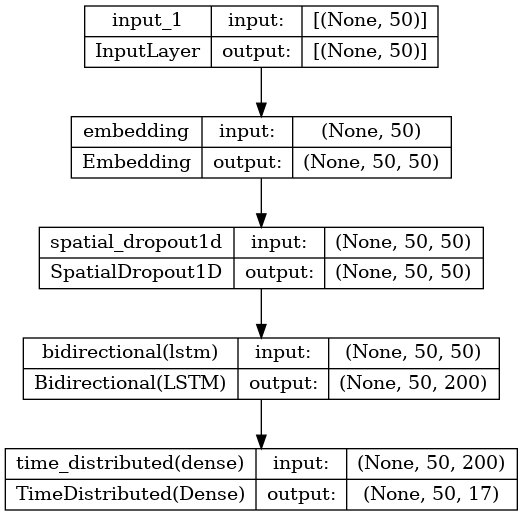

In [24]:
#Showing the model
plot_model(model,show_shapes=True)

# Training the Model with Train set


* During training, the model will learn to minimize the loss function specified in the model compilation step, using the optimizer and learning rate specified in the compilation step as well. 

* The progress of the training will be displayed according to the verbose parameter.

* When verbose=1, the fit() method will display progress information on the training process for each epoch (a complete pass through the training dataset) in the console output. Specifically, it will display the epoch number, the number of samples processed per second, the training loss and any additional metrics that were specified when the model was compiled.

* There are other levels of verbosity available in Keras, such as verbose=0 (no output during training) or verbose=2 (only displays the progress bar during training).

* At the end of training, the model will have learned to make predictions on new input data based on the patterns it has learned from the training data.

# Training the model with Training data

model.fit(X_train,np.array(y_train),batch_size=64,verbose=1,epochs=3,validation_split=0.2)

# Model Evaluation

* The evaluate() method of the model takes the input data and target values of the test dataset as input arguments and returns a list of evaluation metrics. The metrics typically include the loss function value, as well as any additional metrics that were specified when the model was compiled.
 
* In this case, np.array(y_test) is used to ensure that the output labels of the test dataset are converted to a NumPy array, which is the expected format for many machine learning models.

* Overall, the code is used to obtain an objective measure of how well the trained model performs on unseen data, which is a critical step in evaluating and optimizing machine learning models.

In [25]:
# Model Evaluation

model.evaluate(X_test,np.array(y_test))

150/150 [==============================] - 4s 16ms/step - loss: 2.8576 - accuracy: 0.0243


[2.8575751781463623, 0.02433277666568756]

# Test set prediction using the Model

* The following code generates a random sentence index, selects the corresponding sentence from the test dataset X_test and passes it as input to a trained machine learning model called model using the model.predict() method. 

* The predicted output p is then converted to a class label using np.argmax() function along the last axis (-1). 

* This is done because the predicted output is in the form of a probability distribution across different classes, and the class with the highest probability is chosen as the predicted class.

In [26]:
# Model Prediction with Test set

rand_sent=np.random.randint(0,X_test.shape[0])
p=model.predict(np.array([X_test[rand_sent]]))
p=np.argmax(p,axis=-1)

y_true=np.argmax(np.array(y_test),axis=-1)[rand_sent]

print("{:20}{:20}\t{}\n".format("Word","True","Pred"))
print("-"*55)

for (w,t,pred)in zip(X_test[rand_sent],y_true,p[0]):
  print("{:20}{:20}\t{}".format(words[w-1],tags[t],tags[pred]))

1/1 [==============================] - 1s 519ms/step
Word                True                	Pred

-------------------------------------------------------
Three               O                   	O
other               O                   	B-per
policemen           O                   	B-tim
were                O                   	B-eve
wounded             O                   	B-eve
in                  O                   	B-eve
the                 O                   	B-eve
attack              O                   	I-per
.                   O                   	I-per
eight-day           O                   	I-per
eight-day           O                   	B-eve
eight-day           O                   	B-per
eight-day           O                   	B-per
eight-day           O                   	B-per
eight-day           O                   	B-per
eight-day           O                   	B-per
eight-day           O                   	B-per
eight-day           O                   	B-per
ei

Requesting for your feedback and improvements on this notebook.